In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
import time

import matplotlib.pyplot as plt

The Value at Risk (VaR) for coverage $\alpha$ is defined as the maximum amount we could expect to lose with likelihood $p = 1 - \alpha$. Put another way, on no more that $100 \times p \%$ of days should we expect to lose more than the VaR. There are many ways to estimate VaR and none of them are perfect. In fact you should not put complete trust in VaR, it is rather intended as a way to get a sense of how much might be lost in different levels of extreme scenarios, and provide this info to people responsible for risk management.

VaR for a high $\alpha$ is a measure of worst case outcomes. For example one might track their $\alpha = 0.999$ VaR to understand how a 1/1000 crisis event might affect them. Because real distributions tend to diverge and become less and less consistent the further along the tail we go, extreme VaR should be taken with a grain of salt.

### Relationship to Confidence Intervals

For those familiar with confidence intervals, VaR is very similar. The idea of trying to cover a set of possible values with an interval specified by $\alpha$ is similar to how VaR tries to cover a set of possible losses. For those unfamiliar there is a lecture available [here](https://www.quantopian.com/lectures/confidence-intervals).

### Historical (Non-Parametric) VaR

We'll use historical VaR, which looks at previous returns distributions and uses that to compute the $p$ percentile. This percentile is the amount of loss you could reasonably expect to experience with probability $p$, assuming future returns are close to past returns. Again, this isn't perfect, and requires that there is no regime change in which the returns distribution changes. For instance, if your historical window doesn't include any crisis events, your VaR estimate will be far lower than it should be.

To compute historical VaR for coverage $\alpha$ we simply take the $100 \times (1 - \alpha)$ percentile of lowest oberserved returns and multiply that by our total value invested.

We'll compute the VaR for $\alpha = 0.95$.

In [2]:
# OEX components as of 3/31/16
# http://www.cboe.com/products/indexcomponents.aspx?DIR=OPIndexComp&FILE=snp100.doc
oex = ['MMM','T','ABBV','ABT','ACN','ALL','GOOGL','GOOG','MO','AMZN','AXP','AIG','AMGN','AAPL','BAC',
       'BRK-B','BIIB','BLK','BA','BMY','CVS','COF','CAT','CELG','CVX','CSCO','C','KO','CL','CMCSA',
       'COP','CSOT','DHR','DOW','DUK','DD','EMC','EMR','EXC','XOM','FB','FDX','F','GD','GE','GM','GILD',
       'GS','HAL','HD','HON','INTC','IBM','JPM','JNJ','KMI','LLY','LMT','LOW','MA','MCD','MDT','MRK',
       'MET,','MSFT','MDZL','MON','MS','NKE','NEE','OXY','ORCL','PYPL','PEP','PFE','PM','PG','QCOM',
       'RTN','SLB','SPG','SO','SBUX','TGT','TXN','BK','PCLN','TWX','FOXA','FOX','USB','UNP','UPS','UTX',
       'UNH','VZ','V','WMT','WBA','DIS','WFC']
tickers = symbols(oex)
num_stocks = len(tickers)

In [3]:
start = time.time()
data = get_pricing(tickers, fields='close_price', start_date='2006-01-01', end_date='2016-04-04')
end = time.time()
print "Time: %0.2f seconds." % (end - start)

Time: 0.60 seconds.


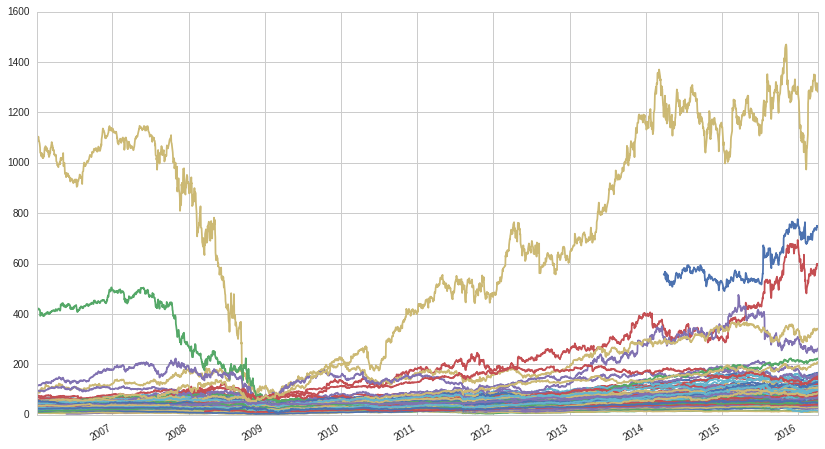

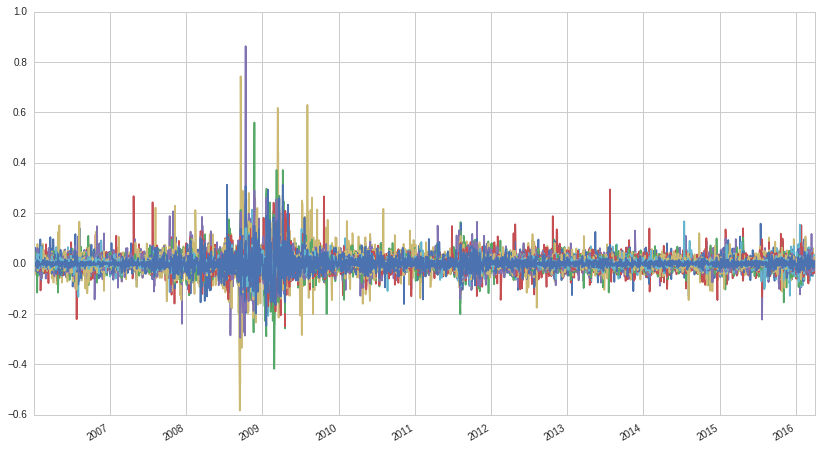

In [4]:
returns = data.pct_change()
returns = returns - returns.mean(skipna=True) # de-mean the returns

data.plot(legend=None);
returns.plot(legend=None); 

We consider an equally weighted portfolio.

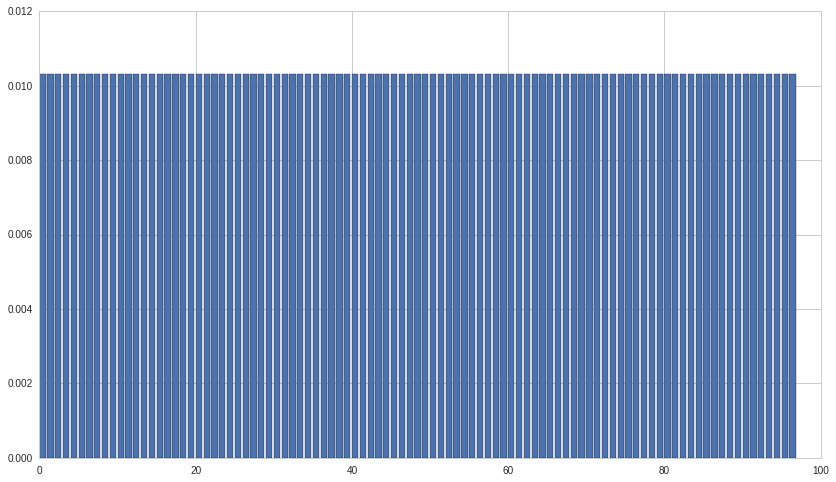

In [5]:
weights = np.ones(num_stocks)/num_stocks
plt.bar(np.arange(num_stocks),weights);

Here portfolio value and returns:

In [6]:
ptf_value = data.fillna(0.0).dot(weights)
ptf_returns = returns.fillna(0.0).dot(weights)

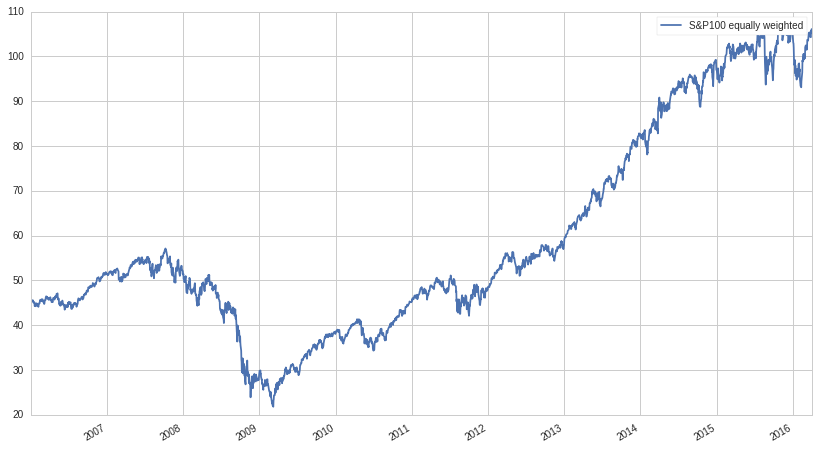

In [7]:
ax = ptf_value.plot(); 
ax.legend(["S&P100 equally weighted"])

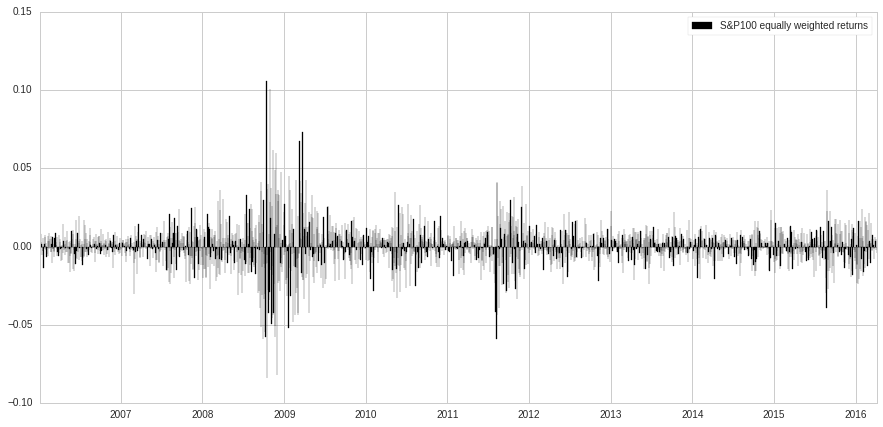

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(ptf_returns.index, ptf_returns, color="k", label="S&P100 equally weighted returns")
ax.legend()

##Historical Simulation

Now let's compute the VaR for $\alpha = 0.95$. We'll write this as $VaR_{\alpha=0.95}$ from now on.

In [9]:
def VaR_HS(ptf_Returns, alpha = 0.95 , Period_Interval = 520, Series = False, removeNa = True):
    '''
    This function can calculate both single value VaR and series of VaR values through time.
    Formula: Historical Simulation.
    '''
    
    # Removes the NAs from the series
    if removeNa==True: ptf_Returns = ptf_Returns[pd.notnull(ptf_Returns)]
    
    if Series == False:
        Data = ptf_Returns[-Period_Interval:]
        Value_at_Risk = -np.percentile(Data,100*(1-alpha))
        
    if Series == True:
        Value_at_Risk = pd.Series(index=ptf_Returns.index, name = 'HSVaR')
        for i in range(0,len(ptf_Returns)-Period_Interval):
            if i == 0: Data = ptf_Returns[-(Period_Interval):]
            else: Data = ptf_Returns[-(Period_Interval+i):-i]
            Value_at_Risk[-i-1] = -np.percentile(Data,1-alpha)
    
    return(Value_at_Risk)

In [10]:
var_hs = VaR_HS(ptf_returns, Series=True)

Compute the exceptions:

In [11]:
var_hs_exc = ptf_returns[ptf_returns > var_hs]

Let's visualize this.

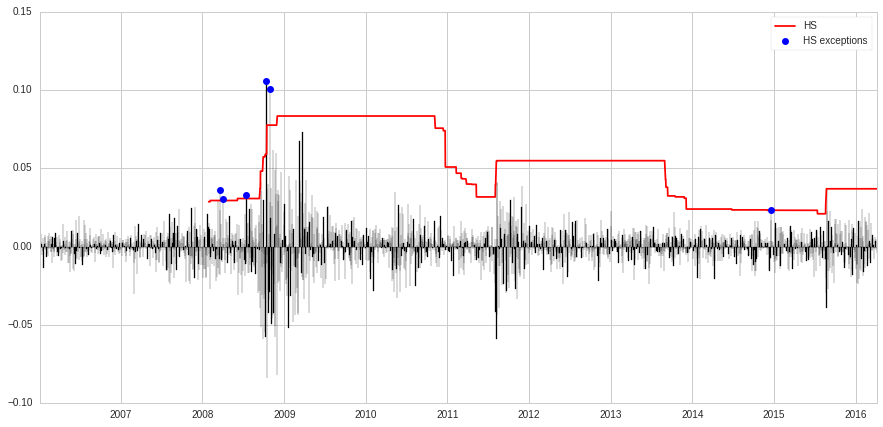

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(ptf_returns.index, ptf_returns, color="k")
ax.plot(var_hs.index, var_hs, color="r", label="HS")
ax.plot(var_hs_exc.index, var_hs_exc, "o", color="blue", label="HS exceptions")
ax.legend()

##Filtered Historical Simulation

In [13]:
def VaR_FHS(ptf_Returns, alpha = 0.95 , Period_Interval = 520, EWMA_Discount_Factor = 0.94, Series = False, removeNa = True):
    '''
    This function can calculate both single value VaR and series of VaR values through time.
    Formula: Filtered Historical Simulation.
    '''
    
    # Removes the NAs from the series
    if removeNa==True: ptf_Returns = ptf_Returns[pd.notnull(ptf_Returns)]
    
    # Defining exponentially smoothed weights components 
    Degree_of_Freedom = np.empty([Period_Interval,])
    Weights = np.empty([Period_Interval,])
    Degree_of_Freedom[0]=1.0
    Degree_of_Freedom[1]=EWMA_Discount_Factor
    Range = range(Period_Interval)
    for i in range(2,Period_Interval):
        Degree_of_Freedom[i]=Degree_of_Freedom[1]**Range[i]
    for i in range(Period_Interval):
        Weights[i]=Degree_of_Freedom[i]/sum(Degree_of_Freedom)


    Value_at_Risk = pd.Series(index=ptf_Returns.index, name = 'FHSVaR')
    EWMAstdev = np.empty([len(ptf_Returns)-Period_Interval,])
    stndrData = pd.Series(index=ptf_Returns.index)

    # For efficiency here we square returns first so the loop does not do it repeadetly 
    sqrdReturns = ptf_Returns**2

    # Computations here happen in different times, because we first need all the EWMAstdev
    # First get the stdev according to the EWMA
    for i in range(0,len(ptf_Returns)-Period_Interval):
        if i == 0: sqrdData = sqrdReturns[-(Period_Interval):]
        else: sqrdData = sqrdReturns[-(Period_Interval+i):-i]

        EWMAstdev[-i-1]=np.sqrt(sum(Weights*sqrdData))

    # Now get the Standardized data by dividing for the EWMAstdev.
    # Length is here -1 because we standardize by the EWMAstdev of the PREVIOUS period.
    # Hence also EWMAstdev is [-i-2] instead of [-i-1].
    for i in range(0,len(ptf_Returns)-Period_Interval-1):
        stndrData[-i-1]=ptf_Returns[-i-1]/EWMAstdev[-i-2]
    stndrData = stndrData[pd.notnull(stndrData)]
    #Finally get the percentile and unfilter back the data
    for i in range(0,len(stndrData)-Period_Interval):
        if i == 0: stndrData2 = stndrData[-(Period_Interval):]
        else: stndrData2 = stndrData[-(Period_Interval+i):-i]   

        stndrData_pct=np.percentile(stndrData2,1-alpha)
    # Unfilter back with the CURRENT stdev
        Value_at_Risk[-i-1]=-(stndrData_pct*EWMAstdev[-i-1])


    # For FHS the single take of VaR does not work because we need to standardize for the preceeding stdev
    # hence it is always necessary to calculate the whole series and take the last value
    if Series == True:
        Value_at_Risk = Value_at_Risk
    if Series == False:
        Value_at_Risk = Value_at_Risk[-1]

    return(Value_at_Risk)

In [ ]:
var_fhs = VaR_FHS(ptf_returns, Period_Interval = 60, EWMA_Discount_Factor = 0.94, Series=True)

Compute the exceptions:

In [ ]:
var_fhs_exc = ptf_returns[ptf_returns > var_fhs]

Let's visualize this.

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(ptf_returns.index, ptf_returns, color="k")
ax.plot(var_fhs.index, var_fhs, color="r", label="FHS")
ax.plot(var_fhs_exc.index, var_fhs_exc, "o", color="blue", label="FHS exceptions")
ax.legend()